# Baseline (pycaret)

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import f1_score

from pycaret.classification import *

import librosa

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pickle
import argparse
import wandb
wandb.init(project="COVID-19", name="pycaret")

parser = argparse.ArgumentParser(description="pycaret")
parser.add_argument('--domain', default="multi_modal", type=str) # multi_modal or audio or tabular
parser.add_argument('--sampling_rate', default=16000, type=int)
parser.add_argument('--top_db', default=60, type=int)
parser.add_argument('--feature', default="mfcc", type=str) # mfcc or melspec
parser.add_argument('--remove_outliers', default=False, type=bool)
parser.add_argument('--over_sampling', default=True, type=bool)
parser.add_argument('--top_n_model', default=5, type=int)
parser.add_argument('--tune_iter', default=10, type=int)
parser.add_argument('--ensemble', default="blend", type=str) # blend or stack
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)

args = parser.parse_args('')

wandb.config.update(args)

domain = args.domain
sampling_rate = args.sampling_rate
top_db = args.top_db
feature = args.feature
remove_outliers = args.remove_outliers
over_sampling = args.over_sampling
top_n_model = args.top_n_model
tune_iter = args.tune_iter
ensemble = args.ensemble
cv = args.cv
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

with open(f'data/pkl/train_df_{sampling_rate}.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open(f'data/pkl/test_df_{sampling_rate}.pkl', 'rb') as f:
    test_df = pickle.load(f)
# with open(f'data/pkl/unlabeled_df_{sampling_rate}.pkl', 'rb') as f:
#     unlabeled_df = pickle.load(f)
    
train_df.head()

,data,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,24,female,0,1,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,51,male,0,0,0
2,"[2.7372453e-09, -1.0615647e-08, 5.2142607e-08,...",3,22,male,0,0,0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,29,female,1,0,0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,23,male,0,0,0


In [2]:
train_df["covid19"].value_counts(normalize=True)

0    0.91958
1    0.08042
Name: covid19, dtype: float64

## Preprocessing

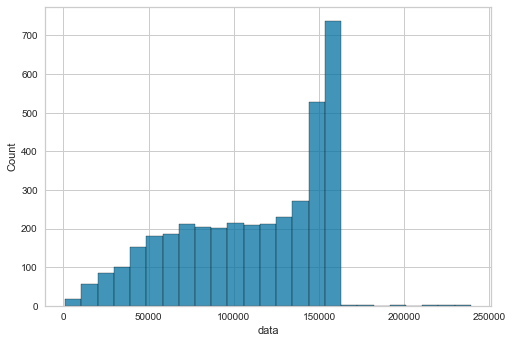

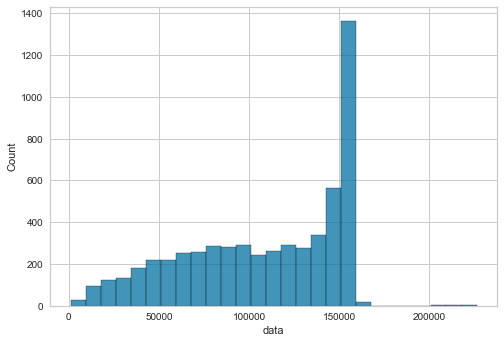

In [3]:
def trim_wav(data, top_db):
    
    frame_length = 0.025
    frame_stride = 0.010

    input_nfft = int(round(sampling_rate*frame_length))
    input_stride = int(round(sampling_rate*frame_stride))
    
    trim_data = data.apply(lambda x : librosa.effects.trim(x, top_db=top_db,
                                                           frame_length=input_nfft,
                                                           hop_length=input_stride)[0])
    return trim_data

train_df["data"] = trim_wav(train_df["data"], top_db)
test_df["data"] = trim_wav(test_df["data"], top_db)

sns.histplot(train_df["data"].apply(lambda x : len(x)))
plt.show()
sns.histplot(test_df["data"].apply(lambda x : len(x)))
plt.show()

In [4]:
def padding_wav(x, reqlen=156027):
    x_len = x.shape[0]
    if reqlen < x_len:
        max_offset = x_len - reqlen
        offset = np.random.randint(max_offset)
        x = x[offset:(reqlen+offset)]
        return x
    elif reqlen == x_len:
        return x
    else:
        total_diff = reqlen - x_len
        offset = np.random.randint(total_diff)
        left_pad = offset
        right_pad = total_diff - offset
        return np.pad(x, (left_pad, right_pad), 'wrap')
    
train_df["data"] = train_df["data"].apply(lambda x : padding_wav(x))
test_df["data"] = test_df["data"].apply(lambda x : padding_wav(x))
    
train_df["data"].apply(lambda x : len(x)).min(), train_df["data"].apply(lambda x : len(x)).max()

(156027, 156027)

In [5]:
def preprocess_dataset(data):

    frame_length = 0.025
    frame_stride = 0.010

    input_nfft = int(round(sampling_rate*frame_length))
    input_stride = int(round(sampling_rate*frame_stride))

    extracted_features = []
    for i in data:
        
        if feature == "mfcc":
            n_feature = 40
            S = librosa.feature.mfcc(y=i,
                                     sr=sampling_rate,
                                     n_mfcc=n_feature,
                                     n_fft=input_nfft,
                                     hop_length=input_stride)
            S_delta = librosa.feature.delta(S)
            S_delta2 = librosa.feature.delta(S, order=2)
            
        elif feature == "melspec":
            n_feature = 128
            S = librosa.feature.melspectrogram(y=i,
                                               sr=sampling_rate,
                                               n_mels=n_feature,
                                               n_fft=input_nfft,
                                               hop_length=input_stride)
            S = librosa.power_to_db(S, ref=np.max)
            S_delta = librosa.feature.delta(S)
            S_delta2 = librosa.feature.delta(S, order=2)

            
        # chroma_stft = librosa.feature.chroma_stft(y=i, sr=sampling_rate,
        #                                           n_fft=input_nfft, hop_length=input_stride, n_chroma=12)
        # chroma_cqt = librosa.feature.chroma_cqt(y=i, sr=sampling_rate,
        #                                         hop_length=input_stride, n_chroma=12)
        # chroma_cens = librosa.feature.chroma_cens(y=i, sr=sampling_rate,
        #                                           hop_length=input_stride, n_chroma=12)
        # rmse = librosa.feature.rms(y=i,
        #                            frame_length=input_nfft, hop_length=input_stride)
        # spec_cent = librosa.feature.spectral_centroid(y=i, sr=sampling_rate,
        #                                               n_fft=input_nfft, hop_length=input_stride)
        # spec_bw = librosa.feature.spectral_bandwidth(y=i, sr=sampling_rate,
        #                                              n_fft=input_nfft, hop_length=input_stride)
        # flatness = librosa.feature.spectral_flatness(y=i,
        #                                              n_fft=input_nfft, hop_length=input_stride)
        # rolloff = librosa.feature.spectral_rolloff(y=i, sr=sampling_rate,
        #                                            n_fft=input_nfft, hop_length=input_stride)
        # zcr = librosa.feature.zero_crossing_rate(y=i,
        #                                          frame_length=input_nfft, hop_length=input_stride)

        # y_feature = np.concatenate((
        #     S.mean(axis=1), S_delta.mean(axis=1), S_delta2.mean(axis=1),
        #     chroma_stft.mean(axis=1), chroma_cqt.mean(axis=1), chroma_cens.mean(axis=1),
        #     rmse.mean(axis=1), spec_cent.mean(axis=1), spec_bw.mean(axis=1),
        #     flatness.mean(axis=1), rolloff.mean(axis=1), zcr.mean(axis=1)
        # ))
            
        S = np.stack((S, S_delta, S_delta2), axis=2)
        y_feature = []
        for e in S:
            y_feature.append(np.mean(e))

        extracted_features.append(y_feature)
        
    return np.array(extracted_features)


def preprocess_feature(df):
    temp = df.copy()
    temp["old"] = temp["age"].apply(lambda x : 1 if x>=65 else 0)
    temp["young"] = temp["age"].apply(lambda x : 1 if x<5 else 0)
    temp["gender_male"] = temp["gender"].apply(lambda x : 1 if x=="male" else 0)
    temp["gender_female"] = temp["gender"].apply(lambda x : 1 if x=="female" else 0)
    temp["gender_other"] = temp["gender"].apply(lambda x : 1 if x=="other" else 0)
    temp["condition1"] = temp["respiratory_condition"] + temp["fever_or_muscle_pain"]
    temp["condition2"] = temp["respiratory_condition"] * temp["fever_or_muscle_pain"]
    temp = temp.drop(["data", "id", "age", "gender"], axis=1)
    return temp

In [6]:
if domain == 'multi_modal':
    
    train_wav = preprocess_dataset(train_df["data"])
    test_wav = preprocess_dataset(test_df["data"])
    
    train_df = preprocess_feature(train_df)
    test_df = preprocess_feature(test_df)
    
    train = pd.concat([pd.DataFrame(train_wav), train_df], axis=1)
    test = pd.concat([pd.DataFrame(test_wav), test_df], axis=1)
    
    print(train.shape, test.shape)

elif domain == 'audio':
    
    train_wav = preprocess_dataset(train_df["data"])
    test_wav = preprocess_dataset(test_df["data"])
    
    train = pd.concat([pd.DataFrame(train_wav), train_df["covid19"]], axis=1)
    test = pd.DataFrame(test_wav)
    
    print(train.shape, test.shape)

elif domain == 'tabular':
    
    train = preprocess_feature(train_df)
    test = preprocess_feature(test_df)
    
    print(train.shape, test.shape)

(3805, 50) (5732, 49)


## Training

In [7]:
s = setup(train, target='covid19',
          normalize=True,
          numeric_features=["condition1"],
          # bin_numeric_features = ["age"],
          remove_outliers=remove_outliers,
          fix_imbalance=over_sampling,
          fold_strategy='stratifiedkfold', fold=cv,
          use_gpu=True, session_id=seed, log_experiment=True)

,Description,Value
0,session_id,1011
1,Target,covid19
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3805, 50)"
5,Missing Values,False
6,Numeric Features,41
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


INFO: 'clf-default-name' does not exist. Creating a new experiment


In [8]:
def macro_f1(true, pred):
    score = f1_score(true, pred, average='macro')
    return score

add_metric('macro_f1', 'macro_f1', macro_f1, greater_is_better=True)

Name                                                  macro_f1
Display Name                                          macro_f1
Score Function       <function macro_f1 at 0x0000023318E335E0>
Scorer                                   make_scorer(macro_f1)
Target                                                    pred
Args                                                        {}
Greater is Better                                         True
Multiclass                                                True
Custom                                                    True
Name: macro_f1, dtype: object

In [9]:
if ensemble=="stack":
    model=stack_models(compare_models(sort='macro_f1', n_select=top_n_model), choose_better=True)
elif ensemble=="blend":
    model=blend_models(compare_models(sort='macro_f1', n_select=top_n_model), choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,macro_f1
Fold,,,,,,,,
0,0.9026,0.5972,0.0952,0.2222,0.1333,0.0904,0.0996,0.5409
1,0.9101,0.7213,0.0952,0.2857,0.1429,0.1078,0.1262,0.5477
2,0.9213,0.5672,0.1905,0.5000,0.2759,0.2430,0.2751,0.6171
3,0.9173,0.6669,0.1500,0.3750,0.2143,0.1790,0.2002,0.5853
4,0.9323,0.7291,0.2000,0.6667,0.3077,0.2828,0.3407,0.6361
5,0.9248,0.5801,0.1500,0.5000,0.2308,0.2031,0.2447,0.5956
6,0.9098,0.5042,0.0000,0.0000,0.0000,-0.0201,-0.0313,0.4764
7,0.8985,0.5110,0.0952,0.2000,0.1290,0.0823,0.0887,0.5376
8,0.9098,0.6515,0.0952,0.2857,0.1429,0.1076,0.1261,0.5476


In [10]:
tuned_model = tune_model(model, n_iter=tune_iter, optimize='macro_f1', search_library='optuna', choose_better=True)
final_model = finalize_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,macro_f1
Fold,,,,,,,,
0,0.8652,0.5586,0.1429,0.1429,0.1429,0.0697,0.0697,0.5348
1,0.8914,0.6498,0.2381,0.2778,0.2564,0.1982,0.1989,0.5989
2,0.8764,0.5592,0.1905,0.2000,0.1951,0.1282,0.1283,0.5641
3,0.9060,0.5756,0.3000,0.3529,0.3243,0.2742,0.2752,0.6369
4,0.9323,0.7045,0.3500,0.5833,0.4375,0.4039,0.4189,0.7008
5,0.9023,0.5618,0.3000,0.3333,0.3158,0.2633,0.2637,0.6316
6,0.9060,0.5520,0.1429,0.3000,0.1935,0.1503,0.1620,0.5718
7,0.8947,0.5457,0.2381,0.2941,0.2632,0.2072,0.2085,0.6032
8,0.8797,0.5625,0.1905,0.2105,0.2000,0.1351,0.1353,0.5675


In [11]:
print("validation_macro-f1 :", pull()["macro_f1"].loc["Mean"])
print("validation_auroc :", pull()["AUC"].loc["Mean"])

wandb.log({
    "validation_macro-f1": pull()["macro_f1"].loc["Mean"],
    "validation_auroc": pull()["AUC"].loc["Mean"]
})

validation_macro-f1 : 0.6008
validation_auroc : 0.5907


In [12]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Inference

In [13]:
predictions = predict_model(final_model, data=test)
test_df['covid19'] = predictions['Label']

test_df['covid19'].value_counts(normalize=True)

0    0.887299
1    0.112701
Name: covid19, dtype: float64

In [14]:
submission = pd.read_csv('data/sample_submission.csv')
submission['covid19'] = test_df['covid19']
submission.to_csv('submission.csv', index=False)

In [15]:
sip = np.sum(train_df["covid19"].value_counts(normalize=True)[1]-test_df["covid19"].value_counts(normalize=True)[1])

print("Sum of Imbalanced Proportions: ", sip)
wandb.log({'Sum of Imbalanced Proportions': sip})

Sum of Imbalanced Proportions:  -0.03228012871006582
